# Large Feature Selection

In [1]:
import matplotlib.pyplot as plt
from sklearn_genetic import GAFeatureSelectionCV
from sklearn_genetic.plots import plot_fitness_evolution, plot_histogram_k_features_hof
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, permutation_test_score, cross_validate
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import numpy as np


c:\Program Files (x86)\Microsoft Visual Studio\Shared\Python39_64\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Create a custom dataset with huge number of features
Output only depends on the first features


In [2]:
data = load_iris()
X, y = data["data"], data["target"]

In [3]:
new_X = np.kron(X, np.random.uniform(-50, 50, size=(1001, ))) + np.random.uniform(-5, 5, size=(150, 4_004))
new_X.shape

(150, 4004)

In [4]:
noise1 = np.random.uniform(-10000, 10000, size=(X.shape[0], 4_999))
noise2 = np.random.gamma(100, scale=100, size=(X.shape[0], 4_999))
noise3 = np.random.hypergeometric(5, 10, 5, size=(X.shape[0], 4_999))
noise4 = np.random.binomial(10, 0.2, size=(X.shape[0], 4_999))

X = np.hstack((new_X, noise1, noise2, noise3, noise4))
X.shape

(150, 24000)

### Split the training and test data

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6)

### Define the GAFeatureSelectionCV options

In [14]:
clf = DecisionTreeClassifier()

evolved_estimator = GAFeatureSelectionCV(
    estimator=clf,
    mutation_probability=0.7,
    cv=10,
    max_features=4096,
    population_size=500,
    generations=50,
    n_jobs=-1,
    verbose=True,
    keep_top_k=100,
    features_proportion=0.0001,
)

### Fit the model and see some results

In [15]:
evolved_estimator.fit(X_train, y_train, val_data=(X_test, y_test))
features = evolved_estimator.support_

# Predict only with the subset of selected features
#y_predict_ga = evolved_estimator.predict(X_test)
#accuracy = accuracy_score(y_test, y_predict_ga)

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	500   	0.408617	0.204877   	0.955551   	0.155551   
1  	1000  	0.687583	0.193524   	0.966659   	0.399993   
2  	1000  	0.902148	0.0235343  	0.966659   	0.866657   
3  	1000  	0.929114	0.0135436  	0.97777    	0.911101   
4  	1000  	0.942446	0.00992176 	0.97777    	0.933324   
5  	1000  	0.952745	0.0075722  	0.97777    	0.944432   
6  	1000  	0.959056	0.00616737 	0.97777    	0.955541   
7  	1000  	0.963156	0.00705413 	0.983321   	0.955546   
8  	1000  	0.968798	0.00444787 	0.983321   	0.96665    
9  	1000  	0.971266	0.00559058 	0.983321   	0.966654   
10 	1000  	0.975453	0.00466903 	0.983321   	0.966657   
11 	1000  	0.977864	0.000738444	0.983321   	0.977761   
12 	1000  	0.977921	0.000915954	0.983321   	0.977763   
13 	1000  	0.977967	0.00103412 	0.983321   	0.977766   
14 	1000  	0.978078	0.00127605 	0.983321   	0.977766   
15 	1000  	0.978234	0.001539   	0.983321   	0.977766   
16 	1000  	0.97839 	0.0017493  	0.983324   	0.97

In [16]:
np.where(features)

(array([2459, 3262], dtype=int64),)

<AxesSubplot: title={'center': 'Histogram of most selected features in HallOfFame'}, xlabel='count', ylabel='feature'>

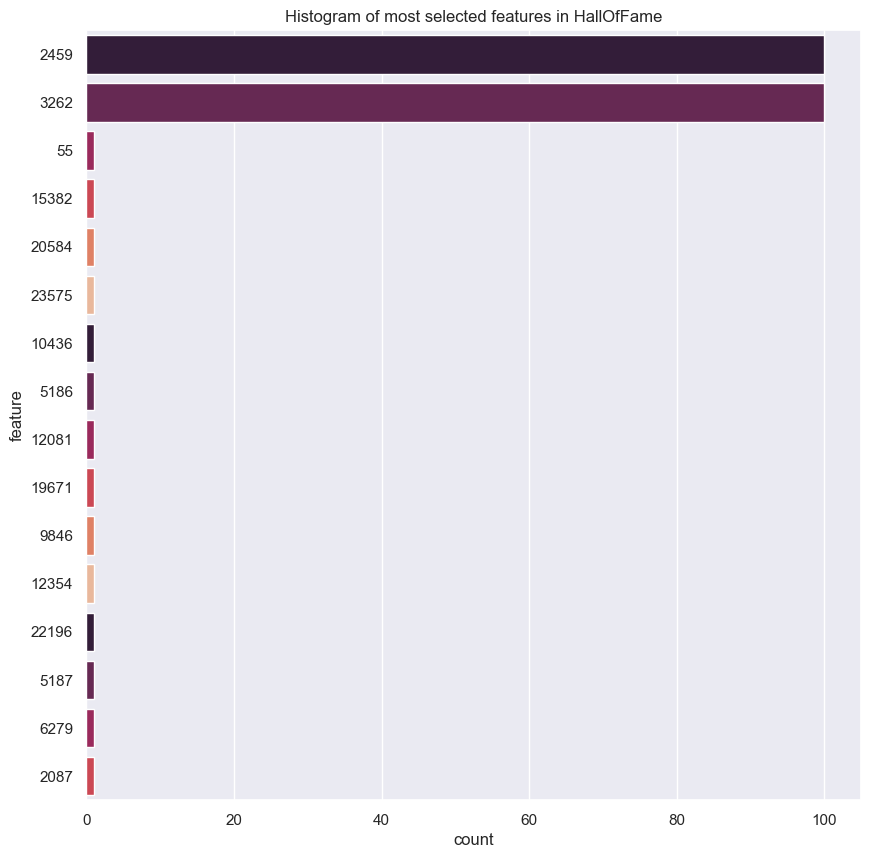

In [17]:
plot_histogram_k_features_hof(evolved_estimator)

Re-doing a feature selection to find a smaller set of features

In [ ]:

clf = DecisionTreeClassifier()

new_estimator = GAFeatureSelectionCV(
    estimator=clf,
    cv=5,
    scoring="accuracy",
    max_features=4,
    population_size=50,
    generations=10,
    n_jobs=-1,
    verbose=True,
    tournament_size=25,
    elitism=True,
)

In [ ]:
new_estimator.fit(X_train[:, evolved_estimator.support_], y_train)
features = new_estimator.support_

# Predict only with the subset of selected features
y_predict_ga = new_estimator.predict(X_test[:, evolved_estimator.support_])
accuracy = accuracy_score(y_test, y_predict_ga)

In [ ]:
#Best features found
print(new_estimator.support_)
print("accuracy score: ", "{:.2f}".format(accuracy))

In [ ]:
np.where(evolved_estimator.support_)[0][new_estimator.support_]

In [ ]:
plot = plot_fitness_evolution(evolved_estimator, metric="fitness")
plot = plot_fitness_evolution(new_estimator, metric="fitness")
plt.show()

# SVC on all features

In [14]:
from sklearn.ensemble import RandomForestClassifier

feature_names = np.array([f"feature {i}" for i in range(X.shape[1])])
forest = RandomForestClassifier()
forest.fit(X_train, y_train)
importances = forest.feature_importances_

In [15]:
forest.score(X_test, y_test)

0.9555555555555556

In [16]:
importances[np.argsort(-importances)[:16]]

array([0.01071547, 0.01007107, 0.01003728, 0.00987994, 0.00981233,
       0.00968782, 0.00964298, 0.00959239, 0.00936772, 0.00936146,
       0.00923095, 0.00922985, 0.00679038, 0.00594179, 0.00586101,
       0.00581991])

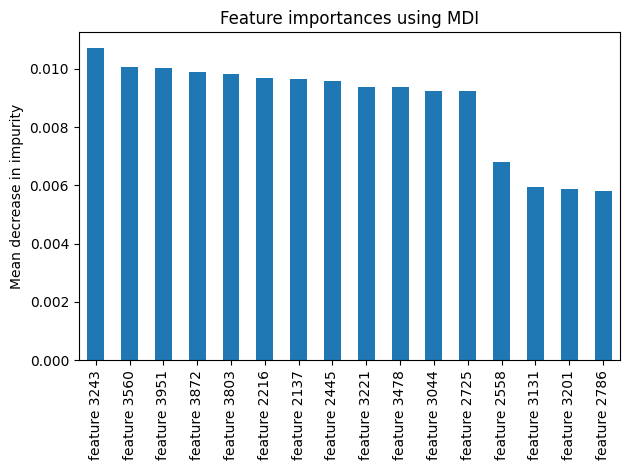

In [17]:
import pandas as pd

forest_importances = pd.Series(importances[np.argsort(-importances)[:16]], index=feature_names[np.argsort(-importances)[:16]])

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# SVC on selected features

In [ ]:
clf = DecisionTreeClassifier()
clf.fit(X_train[:, evolved_estimator.support_][:, new_estimator.support_], y_train)
clf.score(X_test[:, evolved_estimator.support_][:, new_estimator.support_], y_test)